In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import yasa

# Import all the electrodes 
electrodes_all = pd.read_csv('1000Hz/info.txt', header=None, delimiter='\t ', nrows=1, engine='python')
electrodes_all = np.squeeze(electrodes_all.values.tolist())

# use the electrodes that span the motor cortex
first_electrode = np.where(electrodes_all=='CFC7')[0][0]
last_electrode = np.where(electrodes_all=='CCP8')[0][0]
channels = last_electrode - first_electrode + 1

print(first_electrode, last_electrode)
C3_index = np.where(electrodes_all=='C3')[0][0]

electrodes_25 = electrodes_all[first_electrode:last_electrode+1] 
electrodes_25 = np.hstack((electrodes_25, 'MI'))
print(electrodes_25)

events = pd.read_csv('1000Hz/data_set_IVb_al_train_mrk.txt', header=None, sep='\t')
events = np.squeeze(events.values.tolist())
dataframe = np.loadtxt('1000Hz/data_set_IVb_al_train_cnt.txt', delimiter='\t')

C3_df = np.squeeze(dataframe[:, 51])

print(C3_df.shape)
print(dataframe.shape)

fs = 1000

41 65
['CFC7' 'CFC5' 'CFC3' 'CFC1' 'CFC2' 'CFC4' 'CFC6' 'CFC8' 'T7' 'C5' 'C3'
 'C1' 'Cz' 'C2' 'C4' 'C6' 'T8' 'CCP7' 'CCP5' 'CCP3' 'CCP1' 'CCP2' 'CCP4'
 'CCP6' 'CCP8' 'MI']
(2102599,)
(2102599, 118)


In [71]:
# Referencing the EEG data, future to include Cz rereferencing

def reference(ref_type, data, electrodes):
    assert (data.shape[0] > data.shape[1]), "Check your rows are samples and columns are electrodes: " + str(data.shape)        
    
    if (ref_type=='car'):
        ref = data - np.mean(data, axis = 1, keepdims = True)
    elif (ref_type=='cz'):
        cz_index = np.where(electrodes=='Cz')[0][0]
        cz = data[:, cz_index]
        cz = cz.reshape((data.shape[0], 1))
        ref = data - cz
    else:
        return "Error, lol"
    return ref

In [72]:
# Functions for filtering

from scipy.signal import welch, freqz, butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Comparison/check that filtering worked
def plot_spectrum(data, sf, window_sec, band=None, dB=False):
    """Plot the periodogram, Welch's and multitaper PSD.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds for Welch's PSD
    dB : boolean
        If True, convert the power to dB.
    """
    sns.set(style="white", font_scale=1.2)
    # Compute the PSD
    freqs_welch, psd_welch = welch(data, sf, nperseg=window_sec*sf)
    sharey = False

    # Optional: convert power to decibels (dB = 10 * log10(power))
    if dB:
        psd_welch = 10 * np.log10(psd_welch)
        sharey = True
    
    return freqs_welch, psd_welch


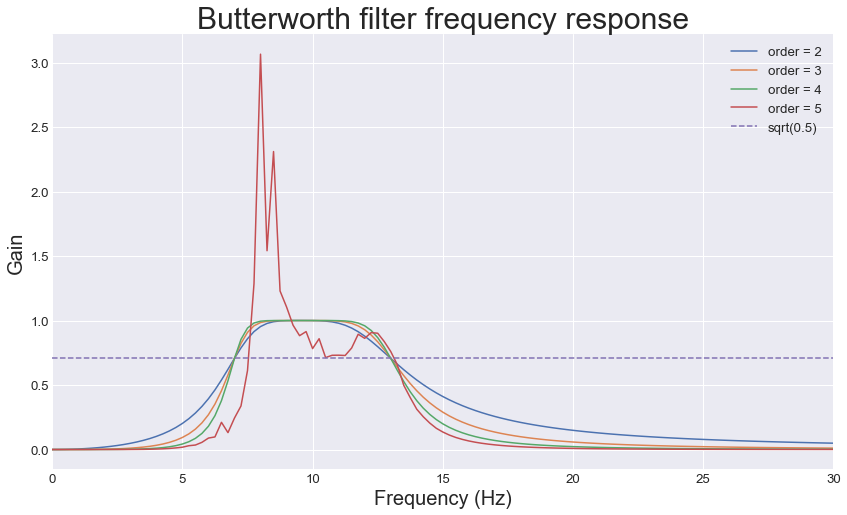

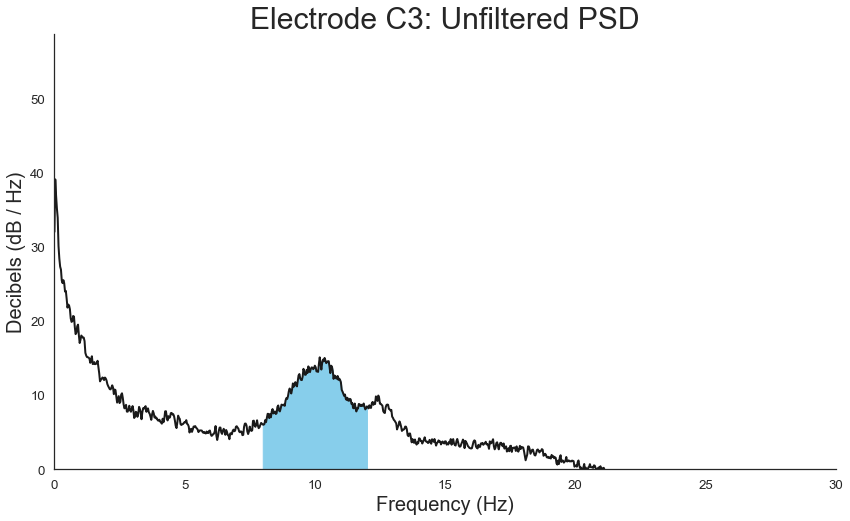

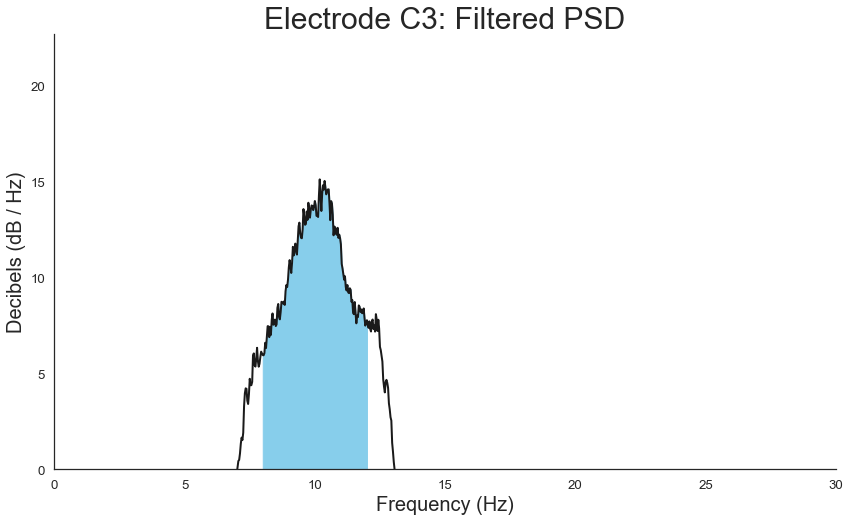

In [73]:
# Plot frequency response, spectrum for unfiltered, test it on C3

# Define band
low = 8
high = 12
margin = 1

# Frequency response
plt.figure(1, figsize=(14, 8))
plt.clf()
for order in [2, 3, 4, 5]:
    b, a = butter_bandpass(low-margin, high+margin, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.title("Butterworth filter frequency response", fontsize=30)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.xlim([0, 30])
plt.ylabel('Gain', fontsize=20)
plt.grid(True)
plt.legend(loc='best')

# Filter
freqs, psd = plot_spectrum(C3_df, fs, (32), [1, 50], dB=True)

# Find intersecting values in frequency vector
idx_mu = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(14, 8))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_mu, color='skyblue')
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Decibels (dB / Hz)', fontsize=20)
plt.xlim([0, 30])
plt.ylim([0, psd.max() * 1.5])
plt.title("Electrode C3: Unfiltered PSD", fontsize=30)
sns.despine()


C3_filt = butter_bandpass_filter(C3_df, low-margin, high+margin, fs, order=4)
freqs, psd = plot_spectrum(C3_filt, fs, (32), [1, 50], dB=True)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(14, 8))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_mu, color='skyblue')
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Decibels (dB / Hz)', fontsize=20)
plt.xlim([0, 30])
plt.ylim([0, psd.max() * 1.5])
plt.title("Electrode C3: Filtered PSD", fontsize=30)
sns.despine()

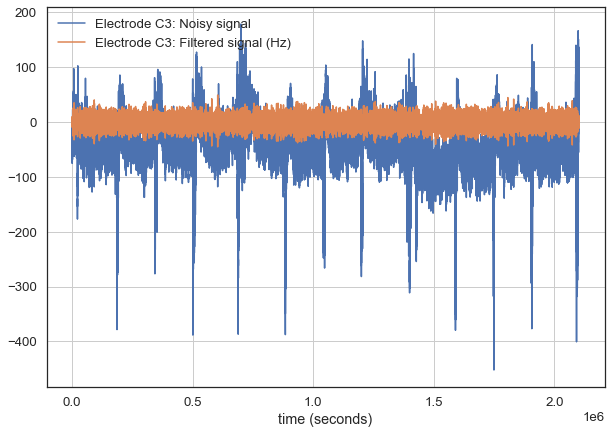

In [74]:
# Create datasets 
unfilt_unref = dataframe
unfilt_unref_cut = unfilt_unref[:, first_electrode:last_electrode+1]

unfilt_ref = reference('car', dataframe, electrodes_all)
unfilt_ref_cut = unfilt_ref[:, first_electrode:last_electrode+1]

# Let's filter boi
# Sample rate and desired cutoff frequencies (in Hz).
filt_unref = np.copy(dataframe)

for i in range(118):
    filt_unref[:, i] = butter_bandpass_filter(unfilt_unref[:, i], low-margin, high+margin, fs, order=4)

time = [i for i in range(filt_unref.shape[0])]
    
plt.figure(1, figsize=(10, 7))
plt.clf()
plt.plot(time, dataframe[:, C3_index], label='Electrode C3: Noisy signal')
plt.plot(time, filt_unref[:, 51], label='Electrode C3: Filtered signal (Hz)' )
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

# Reference the filtered one
filt_ref = reference('car', filt_unref, electrodes_all)
filt_ref_cut = filt_ref[:, first_electrode:last_electrode+1]

In [76]:
# Create function to process eeg

def relative_BP(data, rest_bp, ref_type, filter_bool, print_filter_bool):
    assert (data.shape[0] > data.shape[1]), "Check your rows are samples and columns are electrodes: " + str(data.shape)
       
    if (filter_bool):
        data = bandpass(data, fs, 250, start_freq, end_freq, print_bool=print_filter_bool)
    
    assert (data.shape[1] < data.shape[0]), "How many electrodes you got?: " + str(data.shape)
    assert (rest_bp.shape[1] < rest_bp.shape[0]), "Check your rest_bp size: " + str(rest_bp.shape)
    
    # Calculate relative bandpower
    data_bp = yasa.bandpower(data.T, fs, relative=False)['TotalAbsPow']
    data_bp = data_bp.values.reshape((data_bp.shape[0], 1))

    assert (data_bp.shape == rest_bp.shape), "rest_bp shape: " + str(rest_bp.shape) + " " + "data_bp shape: " + str(data_bp.shape)
    data_rel_bp = 100*np.divide((rest_bp - data_bp), rest_bp)
    
    return data_rel_bp


def run_model(model, x, scale_bool):
    if (scale_bool): 
        x = scaler.transform(x)

    # Make prediction 
    return model.predict(x)

In [78]:
%%time
# Sort into left or right

def choppity_chop_data(data, ntrials, return_avg):
    # Sort the data into their trials for left and right
    channels = data.shape[1]
    behind_event = 1750
    front_event = 5250
    total_len = behind_event + front_event
    
    right = np.zeros((channels, total_len))
    left = np.zeros((channels, total_len))
    
    right_trial_avg = np.zeros((channels, total_len))
    left_trial_avg = np.zeros((channels, total_len))

    print(right.shape, left.shape)

    
    for i in range(ntrials):
        start = events[i][0]
        trial = data[start - behind_event: start + front_event, :].T

        if (events[i][1] == 1):
            right = np.append(right, trial, axis=1)
            right_trial_avg += np.square(trial)
        else:
            left = np.append(left, trial, axis=1)
            left_trial_avg += np.square(trial)
    
    
    right = right[:, total_len:]
    left = left[:, total_len:]
    
    right_sq = np.square(right)
    left_sq = np.square(left)
    
    all_sq = np.concatenate((right_sq, left_sq), axis=1)
    
    
    if (return_avg):
        right_trial_avg /= (ntrials/2)
        left_trial_avg /= (ntrials/2)
        return right_trial_avg, left_trial_avg
    else:
        print(right_sq.shape, left_sq.shape, all_sq.shape)
        return all_sq

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs


In [79]:
%%time
# Create data to train
def create_training_data(data, ntrials, length, increment):
    # Calculate relative bandpower
    trials = ntrials
    channels = 25

    b = length
    c = 0
    inc = increment
    y = []

    temp = np.zeros((channels, 1))
    ERP = np.zeros((channels, 1))

    # Chop data
    all_sq = choppity_chop_data(data, ntrials, False)
    
    # Practically, we would be using rest prerecorded, therefore we should train with it
    rest_bandpower = yasa.bandpower(np.square(data[0:45000, :]).T, fs, relative=False)['TotalAbsPow']
    rest_bandpower = rest_bandpower.values.reshape((rest_bandpower.shape[0], 1))

    for i in range(7000, trials*7000, 7000):
        trial = all_sq[:, i-7000:i]
        ind = events[int(i/7000) - 1][1]

        while (b < 7000 + inc):
            if ((b < 1750) or (b >= 5250)): 
                temp = np.concatenate((temp, 
                                       relative_BP(trial[:, b-250:b].T, rest_bandpower, 'car', False, False)), 
                                       axis = 1)
                y = y + [0]
            elif ((b >= 2750) and (b < 5250)):
                temp = np.concatenate((temp, 
                                       relative_BP(trial[:, b-250:b].T, rest_bandpower, 'car', False, False)), 
                                       axis = 1)
                y = y + [ind]
                
            b += inc
        b = 250
        
        
        temp = np.delete(temp, 0, 1)  

        ERP = np.concatenate((ERP, temp), axis=1)
        temp = np.zeros((channels, 1))
    
    ERP = np.delete(ERP, 0, 1)        
    print(ERP.shape, len(y))
    
    return ERP, y

X_train, Y_train = create_training_data(filt_ref_cut, 210, 250, 10)
Y_train = np.reshape(Y_train, (len(Y_train), 1))

print(X_train.shape, Y_train.shape)

(25, 7000) (25, 7000)
(25, 735000) (25, 735000) (25, 1470000)
(25, 120384) 120384
(25, 120384) (120384, 1)
CPU times: user 12min 7s, sys: 12.5 s, total: 12min 20s
Wall time: 12min 24s


In [80]:
# Load data
X_train = pd.read_csv('training data/unfiltered/unfilt_ref.csv', header=None, delimiter=',').to_numpy().T
Y_train = pd.read_csv('training data/Y_train.csv', header=None, delimiter=',').to_numpy()
X_t = np.hstack((X_train, Y_train))
x = pd.DataFrame(X_t, columns=electrodes_25)

# Code below is for when you ain't importing
# X_t = np.hstack((X_train.T, Y_train))
# x = pd.DataFrame(X_t, columns=electrodes_25)

print(x.shape, Y_train.shape)
x.head()

np.savetxt('training data/Filtered/filt_ref.csv', x)

(120384, 26) (120384, 1)


In [81]:
# Sort out the class imbalance
# How many of each group are there
print(x.groupby('MI').nunique())

# So about 26000 is the max we can get for even classes
ntrials = 26000

x_even = x.groupby('MI').apply(lambda i: i.sample(ntrials)).reset_index(drop=True)
print(x_even.groupby('MI').nunique())

trial_list = [i for i in range(x_even.shape[0])]
y_even = pd.DataFrame(trial_list)
y_even = x_even['MI']

x_even.head()
x_even = x_even.drop(['MI'], axis=1)
x_even.head()

y_even.head()

       CFC7   CFC5   CFC3   CFC1   CFC2   CFC4   CFC6   CFC8     T7     C5  \
MI                                                                           
-1.0  26000  26000  26000  26000  26000  26000  26000  26000  26000  26000   
 0.0  66100  66100  66100  66100  66100  66100  66100  66100  66100  66100   
 1.0  26250  26250  26250  26250  26250  26250  26250  26250  26250  26250   

      ...     C6     T8   CCP7   CCP5   CCP3   CCP1   CCP2   CCP4   CCP6  \
MI    ...                                                                  
-1.0  ...  26000  26000  26000  26000  26000  26000  26000  26000  26000   
 0.0  ...  66100  66100  66100  66100  66100  66100  66100  66100  66100   
 1.0  ...  26250  26250  26250  26250  26250  26250  26250  26250  26250   

       CCP8  
MI           
-1.0  26000  
 0.0  66100  
 1.0  26250  

[3 rows x 25 columns]
       CFC7   CFC5   CFC3   CFC1   CFC2   CFC4   CFC6   CFC8     T7     C5  \
MI                                                       

0   -1.0
1   -1.0
2   -1.0
3   -1.0
4   -1.0
Name: MI, dtype: float64

[[10460    35    22]
 [  209  9713   393]
 [   14    36 10318]]


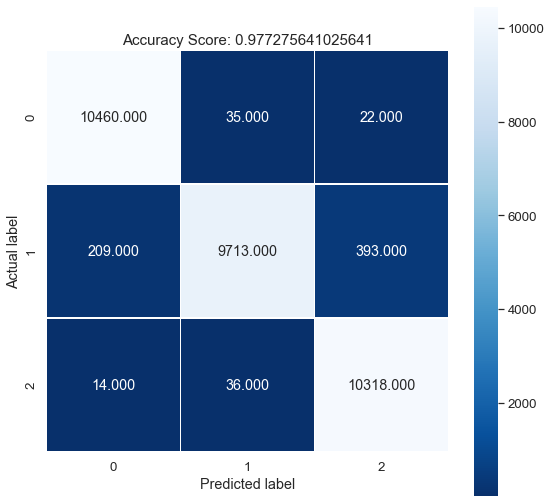

In [82]:
# Classify time baby
x_train, x_test, y_train, y_test = train_test_split(x_even, y_even, test_size=0.4, shuffle=True, random_state=1)
        
scaler = StandardScaler()
scaler.fit(x_train)    
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# Get the model 
# make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='auto'))
# LogisticRegressionCV(multi_class='multinomial')
# DecisionTreeClassifier(criterion='entropy')
# MLPClassifier(activation='relu', 
#                       hidden_layer_sizes=(300, 150), 
#                       alpha=0.0003,
#                       learning_rate='adaptive')
# KNeighborsClassifier(n_neighbors=3)

model = MLPClassifier(activation='relu', 
                      hidden_layer_sizes=(300, 150), 
                      alpha=0.0001,
                      learning_rate='adaptive')
model.fit(x_train, y_train)

# Make predictions on entire test set
predictions = model.predict(x_test)

# Use score method to get accuracy of model
score = model.score(x_test, y_test)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {1}'.format("Neural Net", score)
plt.title(all_sample_title, size = 15);

In [83]:
# Real time classifying time!
def MI_Classification(model, data, rest_bp, fs, ref_type, min_freq, max_freq):
    data_ref = reference('car', data, electrodes_all)
    data_ref_cut = data_ref[:, first_electrode:last_electrode+1].T
    data_ref_cut = np.square(data_ref_cut)
    
    assert (data_ref_cut.shape[0] < data_ref_cut.shape[1]), "Make sure rows are electrodes and columns are samples"
    
    rel_bp = relative_BP(data_ref_cut.T, rest_bp, 'car', False, False).T
    prediction = run_model(model, rel_bp, True)
    
    return prediction

In [85]:
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')

def test_BCI_controller(data, test_num, increment):
    before = 1750
    after = 5250
    time = [i for i in range(-1500, 5250, increment)]
    
    data_ref = reference('car', data, electrodes_all)
    rest_bandpower = yasa.bandpower(np.square(data_ref[0:45000, :]).T, fs, relative=False)['TotalAbsPow']
    rest_bandpower = rest_bandpower.values.reshape((rest_bandpower.shape[0], 1))
    rest_bandpower_cut = rest_bandpower[first_electrode:last_electrode+1, :]
    results = []
    
    for x in range(test_num):
        start = events[x][0]
        hand = events[x][1]
        trial = data[start - before:start+after, :]
        predictions = []
        correct = []
        
        a = 0
        b = 250
        while(b < before + after):
            predictions.append([MI_Classification(model, trial[a:b, :], rest_bandpower_cut, fs, 'car', 8, 12)][0][0])
            
            if ((b < 1750) or (b >= 5250)): 
                correct.append(0)
            else:
                correct.append(hand)
                
            a += increment
            b += increment
        a = 0
        b = 0
        
        smoothed = savgol_filter(predictions, 17, 1)
        
        if (hand == 1):
            if (1.0 in smoothed):
                results = results + [1]
            else:
                results = results + [-1]
        else:
            if (-1.0 in smoothed):
                results = results + [-1]
            else:
                results = results + [1]
        sns.set(font_scale=1.2, style='white')
        plt.style.use('seaborn-darkgrid')
        plt.figure(figsize=(8, 4))
        plt.plot(time, smoothed)
        plt.plot(time, correct)
        plt.xlabel('Time (ms)')
        plt.ylabel('Predicted Label')
        plt.title("MI prediction in time domain: " + "trial #"  + str(x + 1))
        plt.savefig("Graphs/Time Series/NN/Trial " + str(x + 1) + '.png')
        sns.despine()
        
            
    return results, smoothed


CPU times: user 19.5 s, sys: 5.32 s, total: 24.8 s
Wall time: 10 s


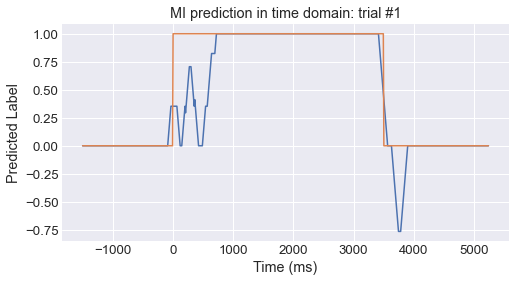

In [86]:
%%time
# Run test
answers, graph = test_BCI_controller(unfilt_unref, 1, 9)
# print(len(graph))

# np.savetxt('output_graph_L.csv', graph, fmt='%f', delimiter=',')
# np.savetxt('NN_trial_pred.txt', answers, fmt='%d', delimiter=',')

In [69]:
# K-Fold test

from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=10, shuffle=True)
y_df = pd.DataFrame(y_even).T


def get_score(model, x_train, x_test, y_train, y_test):
    x_train = x_train.T
    x_test = x_test.T
    
    scaler.fit(x_train)    
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    model.fit(x_train, y_train.values.ravel())

    # Make predictions on entire test set
    predictions = model.predict(x_test)

    # Calculate score
    score = np.around(model.score(x_test, y_test.values.ravel()), 4)

    # Confusion matrix
    cm = metrics.confusion_matrix(y_test.values.ravel(), predictions)
    print(cm)
    # Plot confusion matrix
#     plt.figure(figsize=(4,4))
#     sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
#     plt.ylabel('Actual label');
#     plt.xlabel('Predicted label');
#     all_sample_title = '{0} accuracy: {1}'.format('K-Fold CV:', np.around(score, 4))
#     plt.title(all_sample_title, size = 15);
    
    return score


NN_model = MLPClassifier(activation='relu', 
                      hidden_layer_sizes=(300, 150), 
                      alpha=0.0001,
                      learning_rate='adaptive')
logreg = LogisticRegression(max_iter=1000)
DT = DecisionTreeClassifier(criterion='entropy')
KNN = KNeighborsClassifier(n_neighbors=3)
avg = 0
count = 0


for train_index, test_index in kf.split(x_even, y_even):
    x_train, x_test = x_even.T[train_index], x_even.T[test_index]
    y_train, y_test = y_df[train_index], y_df[test_index]
    score = get_score(NN_model, x_train, x_test, y_train, y_test)
    print(score)
    avg += score
    count += 1
print("Neural network mean accuracy: " + str(avg/count))
avg = 0
count = 0


for train_index, test_index in kf.split(x_even, y_even):
    x_train, x_test = x_even.T[train_index], x_even.T[test_index]
    y_train, y_test = y_df[train_index], y_df[test_index]
    score = get_score(KNN, x_train, x_test, y_train, y_test)
    print(score)
    avg += score
    count += 1
print("KNN mean accuracy: " + str(avg/count))
avg = 0
count = 0


# for train_index, test_index in kf.split(x_even, y_even):
#     x_train, x_test = x_even.T[train_index], x_even.T[test_index]
#     y_train, y_test = y_df[train_index], y_df[test_index]
#     score = get_score(logreg, x_train, x_test, y_train, y_test)
#     print(score)
#     avg += score
#     count += 1
# print("Logistic regression mean accuracy: " + str(avg/count))
# avg = 0
# count = 0


# for train_index, test_index in kf.split(x_even, y_even):
#     x_train, x_test = x_even.T[train_index], x_even.T[test_index]
#     y_train, y_test = y_df[train_index], y_df[test_index]
#     score = get_score(DT, x_train, x_test, y_train, y_test)
#     print(score)
#     avg += score
#     count += 1
# print("Decision tree mean accuracy: " + str(avg/count))

[[2587   13    0]
 [  28 2556   16]
 [   5   24 2571]]
0.989
[[2588   10    2]
 [  34 2540   26]
 [   3   34 2563]]
0.986
[[2575   16    9]
 [  48 2508   44]
 [   3   13 2584]]
0.9829
[[2581   15    4]
 [  23 2511   66]
 [   0    5 2595]]
0.9855
[[2587   13    0]
 [  20 2552   28]
 [   7   43 2550]]
0.9858
[[2566   32    2]
 [  28 2535   37]
 [   0   10 2590]]
0.986
[[2575   23    2]
 [  39 2535   26]
 [   6   23 2571]]
0.9847
[[2531   58   11]
 [  28 2544   28]
 [   4   57 2539]]
0.9762
[[2597    1    2]
 [  20 2551   29]
 [   2    6 2592]]
0.9923
[[2570   21    9]
 [  19 2538   43]
 [   0    9 2591]]
0.9871
Neural network mean accuracy: 0.9855499999999999
[[2599    1    0]
 [  42 2512   46]
 [   2    3 2595]]
0.9879
[[2595    3    2]
 [  55 2498   47]
 [   1    5 2594]]
0.9855
[[2594    5    1]
 [  40 2513   47]
 [   0    3 2597]]
0.9877
[[2596    4    0]
 [  58 2498   44]
 [   0    5 2595]]
0.9858
[[2596    3    1]
 [  56 2499   45]
 [   1    5 2594]]
0.9858
[[2595    4    1]
 [  61